### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from functools import reduce
import pandas_profiling

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import Imputer, RobustScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore');


### Importing the data

In [2]:
'''
The tables only have one column that pandas gave problems with, 
so changing the name to something simple
'''

borrower = pd.read_csv("ds-borrower.csv", names = ['column'])
application = pd.read_table("ds-app.tsv", names = ['column'])
credit = pd.read_table("ds-credit.tsv", names = ['column'])
result = pd.read_table("ds-result.tsv", names = ['column'])



### Visually Inspecting the Data

In [3]:
borrower.sample(2)

,column
157,466 1 3 30 rent self 1
681,38 7 4 43 owned skilled 2


In [4]:
application.sample(2)

,column
493,644 9 busin 1391 2 none
499,519 10 goods 1275 4 none


In [5]:
credit.sample(2)

,column
57,77 none paid high 1
542,82 none paid some 1


In [6]:
result.sample(2)

,column
327,328 N
1452,702 Y


In [7]:
# Parsing the 'column' to multiple columns

borrower['column'].str.split().tolist()
borrower = pd.DataFrame(borrower['column'].str.split().tolist(), columns="CustomerID YearsAtCurrentEmployer YearsInCurrentResidence Age RentOrOwnHome TypeOfCurrentEmployment NumberOfDependantsIncludingSelf".split())
borrower = borrower.drop(borrower.index[0])
borrower = borrower[borrower['YearsAtCurrentEmployer'] != 'Mvd']
borrower['YearsAtCurrentEmployer'] = borrower['YearsAtCurrentEmployer'].replace('10+', '10')

application['column'].str.split().tolist()
application = pd.DataFrame(application['column'].str.split().tolist(), columns="CustomerID LoanPayoffPeriodInMonths LoanReason RequestedAmount InterestRate Co-Applicant".split())
application = application.drop(application.index[0])

credit['column'].str.split().tolist()
credit = pd.DataFrame(credit['column'].str.split().tolist(), columns="CustomerID CheckingAccountBalance DebtsPaid SavingsAccountBalance CurrentOpenLoanApplications".split())
credit = credit.drop(credit.index[0])

result['column'].str.split().tolist()
result = pd.DataFrame(result['column'].str.split().tolist(), columns="CustomerID WasTheLoanApproved".split())
result = result.drop(result.index[0])

print("Borrower data shape: {}".format(borrower.shape))
print("Application data shape: {}".format(application.shape))
print("Credit data shape: {}".format(credit.shape))
print("Results data shape: {}".format(result.shape))




Borrower data shape: (749, 7)
Application data shape: (747, 6)
Credit data shape: (748, 5)
Results data shape: (1501, 2)


In [8]:
'''
Creating a new feature 'interest' to calculate -
the interest payments to be collected
'''

application['interest'] = ((application['RequestedAmount'].astype(int) * 
                                        application['InterestRate'].astype(int)) / 100) * (application['LoanPayoffPeriodInMonths'].astype(int)/12)

In [9]:
# Changing the target variable to binary

result['WasTheLoanApproved'] = \
result['WasTheLoanApproved'].apply(lambda x: 1 if x == "Y" else 0)


In [10]:
# Merging the dataframes

data_frames = [borrower, application, credit, result]

df_merged = reduce(lambda x,y: pd.merge(x,y, on='CustomerID', 
                                        how='outer', ), data_frames)
df_merged = df_merged.drop_duplicates()
df_merged = df_merged.drop(df_merged.tail(2).index)
print(df_merged.shape)

(849, 18)


In [12]:
df_merged.sample(10)

,CustomerID,YearsAtCurrentEmployer,YearsInCurrentResidence,Age,RentOrOwnHome,TypeOfCurrentEmployment,NumberOfDependantsIncludingSelf,LoanPayoffPeriodInMonths,LoanReason,RequestedAmount,InterestRate,Co-Applicant,interest,CheckingAccountBalance,DebtsPaid,SavingsAccountBalance,CurrentOpenLoanApplications,WasTheLoanApproved
1214,218,0,4,23,rent,skilled,1,15,auto,2511,1,none,31.3875,debt,paid,some,1,1.0
846,474,7,4,27,owned,skilled,1,24,goods,3552,3,none,213.1200,debt,paid,some,1,0.0
1152,517,10,1,41,owned,skilled,1,NaN,NaN,NaN,NaN,NaN,NaN,some,delayed,some,1,1.0
625,200,4,3,54,owned,self,1,24,busin,4591,2,none,183.6400,none,paid,v.high,3,0.0
699,230,4,2,40,owned,unskill,1,12,goods,701,4,none,28.0400,debt,paid,some,1,1.0
649,510,7,4,40,owned,skilled,1,NaN,NaN,NaN,NaN,NaN,NaN,none,delayed,high,2,1.0
832,578,1,3,25,rent,skilled,1,18,goods,3213,1,none,48.1950,some,paid,high,1,1.0
1476,7,NaN,NaN,NaN,NaN,NaN,NaN,12,auto,1413,3,none,42.3900,none,paid,v.high,1,1.0
1095,133,1,2,33,owned,skilled,1,24,goods,6403,1,none,128.0600,some,delayed,some,1,1.0
803,657,7,1,25,owned,skilled,1,24,busin,1258,4,none,100.6400,none,paid,some,1,1.0


In [13]:
# # Small function that shows the missing value percentages per column

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("The dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values_table(df_merged)

The dataframe has 18 columns.
There are 17 columns that have missing values.


,Missing Values,% of Total Values
RequestedAmount,102,12.0
Co-Applicant,102,12.0
LoanPayoffPeriodInMonths,102,12.0
LoanReason,102,12.0
interest,102,12.0
InterestRate,102,12.0
CurrentOpenLoanApplications,101,11.9
SavingsAccountBalance,101,11.9
DebtsPaid,101,11.9
CheckingAccountBalance,101,11.9


Approved Loans = 515
Denied Loans = 235


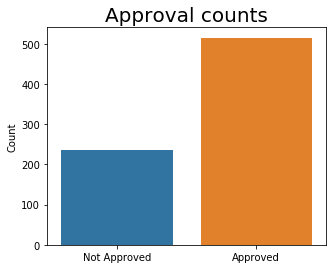

In [14]:
yes_ = df_merged[df_merged['WasTheLoanApproved'] == 1].shape[0] 
no_ = df_merged[df_merged['WasTheLoanApproved'] == 0].shape[0]
plt.figure(figsize=(5, 4))
sns.countplot(df_merged["WasTheLoanApproved"])
plt.xticks((1, 0), ["Approved", "Not Approved"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Approval counts", y=1, fontdict={"fontsize": 20});

print(f"Approved Loans = {yes_}")
print(f"Denied Loans = {no_}")


In [15]:
# The above graph shows that we're working with an imbalanced dataset

### Preparing the data for modeling

In [16]:
# Ordinal Features

# df_merged['RentOrOwnHome'] = df_merged['RentOrOwnHome'].replace(
#     {'owned': 2, 'free': 1, 'rent': 0})

# df_merged['CheckingAccountBalance'] = df_merged['CheckingAccountBalance'].replace(
#     {'high':3, 'some': 2, 'none': 1, 'debt': 0})

# df_merged['DebtsPaid'] = df_merged['DebtsPaid'].replace(
#     {'paid': 1, 'delayed': 0})

# df_merged['SavingsAccountBalance'] = df_merged['SavingsAccountBalance'].replace(
#     {'v.high': 4, 'high': 3, 'medium': 2, 'some': 1, 'none' : 0})

# df_merged['Co-Applicant'] = df_merged['Co-Applicant'].replace(
#     {'co-app': 2, 'guarant': 1, 'none': 0})


# Ordinal features didn't improve the scores

In [17]:
df_merged.dtypes

CustomerID                          object
YearsAtCurrentEmployer              object
YearsInCurrentResidence             object
Age                                 object
RentOrOwnHome                       object
TypeOfCurrentEmployment             object
NumberOfDependantsIncludingSelf     object
LoanPayoffPeriodInMonths            object
LoanReason                          object
RequestedAmount                     object
InterestRate                        object
Co-Applicant                        object
interest                           float64
CheckingAccountBalance              object
DebtsPaid                           object
SavingsAccountBalance               object
CurrentOpenLoanApplications         object
WasTheLoanApproved                 float64
dtype: object

In [18]:
# Converting str values to float
float_cols = ['Age','NumberOfDependantsIncludingSelf', 
              'LoanPayoffPeriodInMonths', 'RequestedAmount', 
              'InterestRate','CurrentOpenLoanApplications',
             'YearsAtCurrentEmployer', 'YearsInCurrentResidence', 
              'interest']

for coll in float_cols:
    df_merged[coll] = df_merged[coll].astype(float)

# Creating the Categorical Values
categoricals = ['TypeOfCurrentEmployment',
                'LoanReason','Co-Applicant','CheckingAccountBalance',
                'DebtsPaid','SavingsAccountBalance', 'RentOrOwnHome',]

for col in categoricals:
    df_merged[col] = df_merged[col].astype('category')


In [19]:
# Dropping the Customer ID column.
df_merged = df_merged.drop('CustomerID', axis = 1)


In [20]:
# Removing rows with na values in the target column

df_merged = df_merged[~df_merged['WasTheLoanApproved'].isnull()]


'''
Removing the null values from the below 4 most importand features 
ended up with slightly better scores for AUC, 
but worse scores for accuracy
'''

# # Removing rows with na values in the top features columns
# df_merged = df_merged[~df_merged['RequestedAmount'].isnull()]
# df_merged = df_merged[~df_merged['CheckingAccountBalance'].isnull()]
# df_merged = df_merged[~df_merged['LoanPayoffPeriodInMonths'].isnull()]
# df_merged = df_merged[~df_merged['Age'].isnull()]


'\nRemoving the null values from the below 4 most importand features \nended up with slightly better scores for AUC, \nbut worse scores for accuracy\n'

In [ ]:
df_merged.hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118ee03c8>,
      dtype=object)

In [253]:
pandas_profiling.ProfileReport(df_merged)

Number of variables,18
Number of observations,750
Total Missing (%),10.7%
Total size in memory,70.7 KiB
Average record size in memory,96.6 B
Numeric,10
Categorical,7
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [254]:
# Generating dummy features for the categoricals

loan_features = df_merged.drop('WasTheLoanApproved',axis = 1) #c/out this
loan_approval = df_merged['WasTheLoanApproved']

df_merged = pd.get_dummies(loan_features, drop_first=True) #c/out this

df_merged = df_merged.reset_index(drop=True)


In [255]:
'''
Splitting the data, 90:10 split. 
The first tries were with the standard 80:20 split, 
but this is a small dataset and the 90:10 split provided better results.
'''

X_train, X_test, y_train, y_test = train_test_split(df_merged, loan_approval, 
                                                    test_size = 0.10, shuffle = True, 
                                                    random_state = 123)

print(f"Original data shapes: {X_train.shape, X_test.shape}")



Original data shapes: ((675, 29), (75, 29))


In [256]:
'''
Impute the missing data using features means. 
Using Median or most_frequent instead of mean provides similar results.
'''

imp = Imputer(strategy = 'mean')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)


In [257]:
# Function to plot the learning curve - checking for overfitting

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Balanced Random Forest

In [258]:
# Grid Search 
# Computationally VERY expensive

# rfc = RandomForestClassifier(random_state=123)
# # rfc.fit(X_train,y_train)

# param_grid = { 
#     'n_estimators': [200, 500, 1000],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6],
#     'criterion' :['gini', 'entropy'],
#     'max_features' :[0.1, 0.25, 0.50, 1]
# }

# scorers = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     'accuracy_score': make_scorer(accuracy_score)
# }


# CV_rfc = GridSearchCV(estimator = rfc, scoring=scorers, param_grid = param_grid, cv = 10, refit = False)

# CV_rfc.fit(X_train, y_train)

# CV_rfc.best_params_

In [259]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score

# Ensemble classifier using samplers internally

brf = BalancedRandomForestClassifier(n_estimators = 50, 
                                     random_state=123,
                                     n_jobs = -1, 
                                     max_depth = 2, 
                                     criterion = 'entropy')

pip_baseline = make_pipeline(RobustScaler(), brf)
scores = cross_val_score(pip_baseline,
                         X_train, y_train,
                         scoring = "roc_auc", cv = 5)


brf.fit(X_train, y_train)
y_pred_brf = brf.predict(X_test)


print("\n========================================================")
print(" Results from Balanced RF Model" )
print("========================================================")
print("\n")
print(f"Balanced RF Model's average AUC: {scores.mean():.3f}")
print("\n")
print(classification_report(y_test, y_pred_brf))
print("\n========================================================")

print("\n")
print(f"Stacked Model's Accuracy Score is: {accuracy_score(y_true, y_pred_brf)}")
print(f"Stacked Model's Precision Score is {precision_score(y_true, y_pred_brf, average='weighted')}")
print("\n")




 Results from Balanced RF Model


Balanced RF Model's average AUC: 0.732


              precision    recall  f1-score   support

         0.0       0.56      0.72      0.63        25
         1.0       0.84      0.72      0.77        50

   micro avg       0.72      0.72      0.72        75
   macro avg       0.70      0.72      0.70        75
weighted avg       0.75      0.72      0.73        75




Stacked Model's Accuracy Score is: 0.72
Stacked Model's Precision Score is 0.7456395348837209




<Figure size 800x400 with 0 Axes>

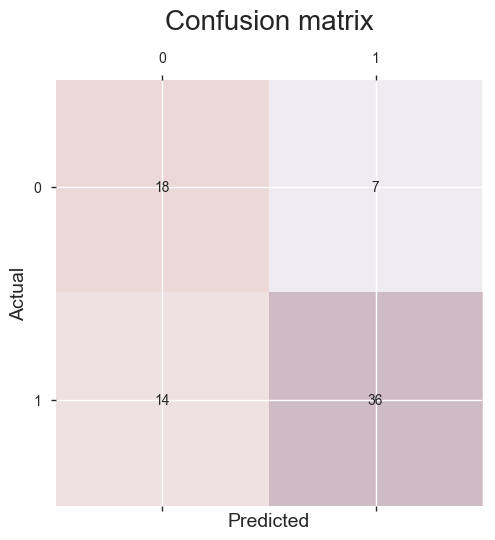

In [260]:
# Random Forest Confusion Matrix
y_true = y_test
conf_mat = confusion_matrix(y_true, y_pred_brf)
plt.figure(figsize=(8, 4))
plt.matshow(conf_mat, cmap = plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x = j, y = i, s = conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

<module 'matplotlib.pyplot' from '/Users/yuce/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

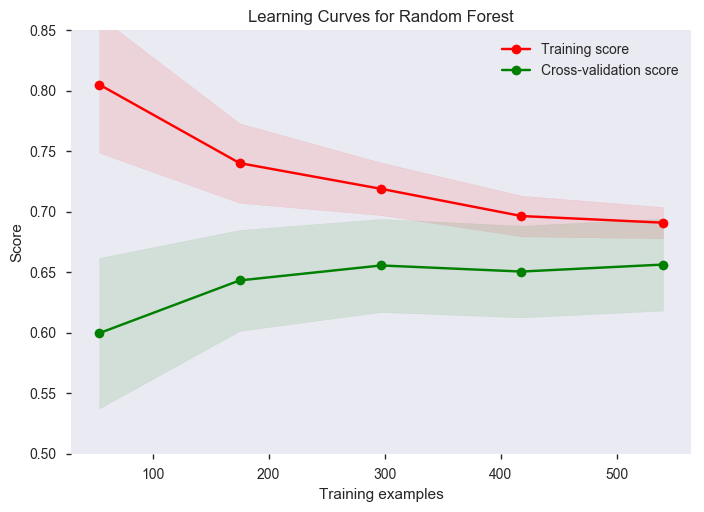

In [261]:
# Random Forest Learning Curve

title = "Learning Curves for Random Forest"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = BalancedRandomForestClassifier(n_estimators = 50, random_state=123,
                                                     n_jobs = -1, max_depth = 2)

plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.5, 0.85), cv=cv, n_jobs=4)


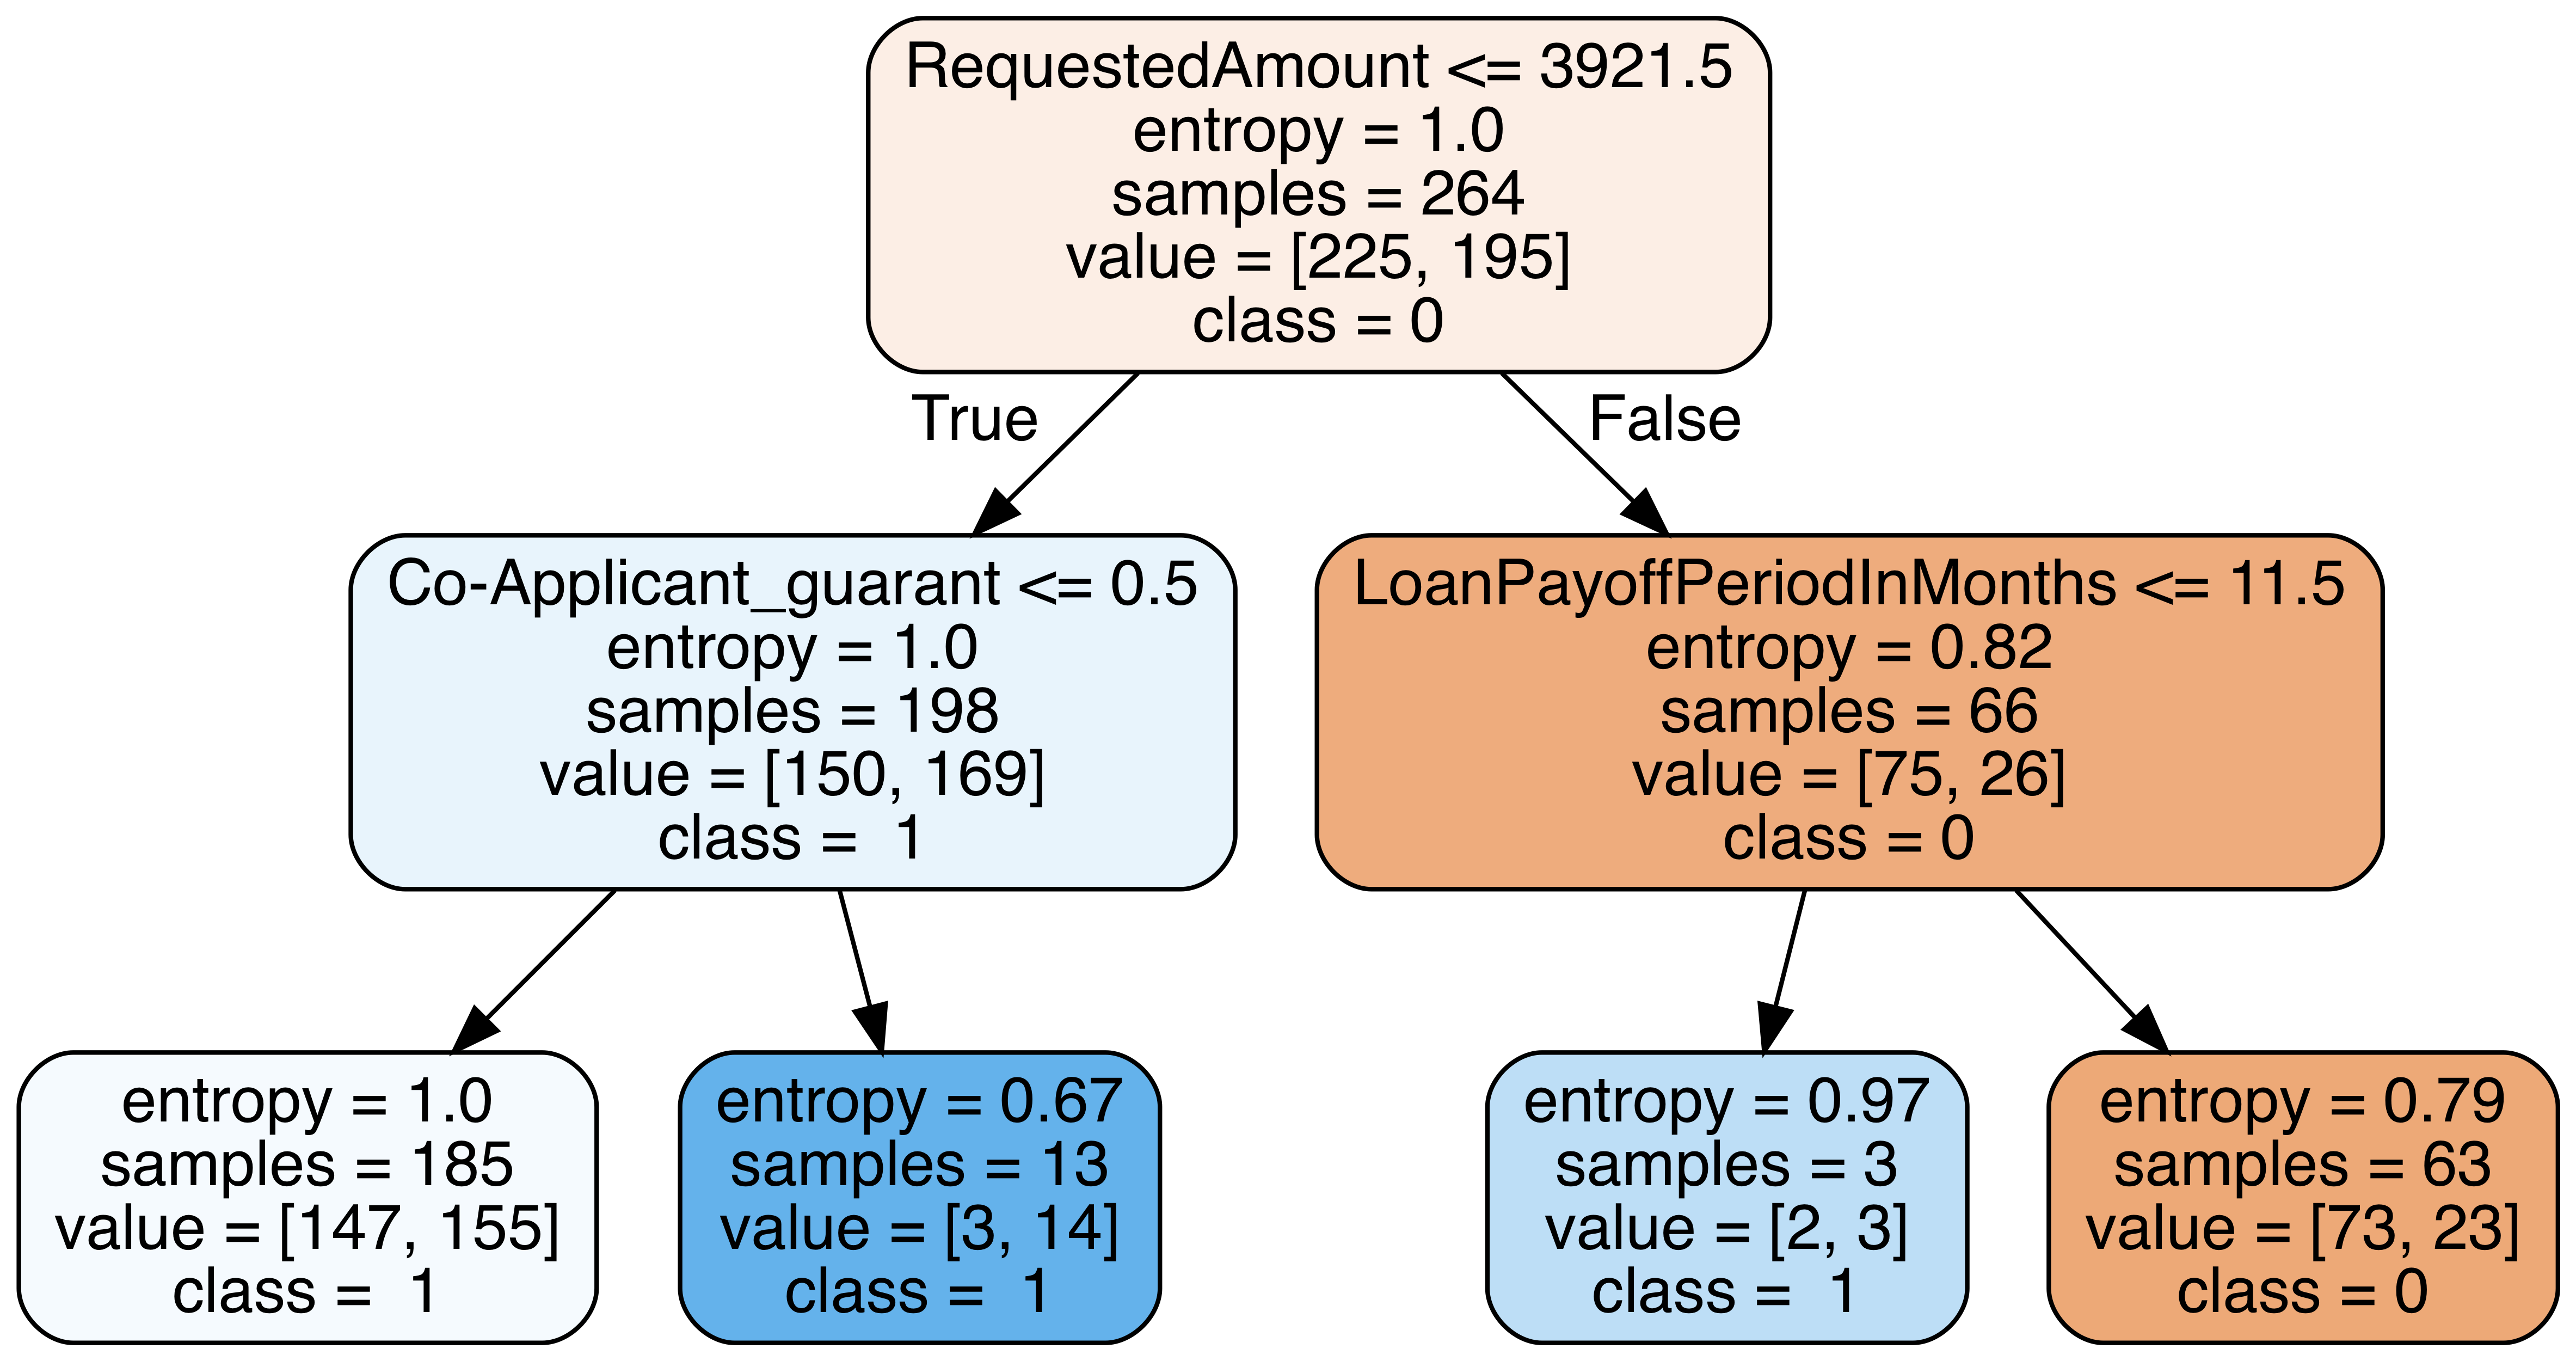

In [262]:
from sklearn.tree import export_graphviz
# Export as dot file
estimator = brf.estimators_[5]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = df_merged.columns.tolist(),
                class_names = ['0',' 1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [263]:
# Plot features importance

importances = brf.feature_importances_
indices = np.argsort(brf.feature_importances_)[::-1]
# plt.figure(figsize = (14, 10))
# plt.barh(df_merged.columns[df_merged.columns != "WasTheLoanApproved"][indices], importances[indices], alpha=0.5, )
# plt.title('RF Feature Importance')

feat_imp = pd.Series(importances[indices], df_merged.columns[df_merged.columns != "WasTheLoanApproved"][indices])

print("\n========================================================")
print("Feature Importance" )
print("========================================================")
print("\n")

print(feat_imp)


Feature Importance


CheckingAccountBalance_none        0.244784
RequestedAmount                    0.148100
Age                                0.140423
interest                           0.078746
YearsAtCurrentEmployer             0.070191
LoanPayoffPeriodInMonths           0.065521
SavingsAccountBalance_some         0.043060
DebtsPaid_paid                     0.037894
SavingsAccountBalance_none         0.030005
CurrentOpenLoanApplications        0.019623
LoanReason_goods                   0.016875
CheckingAccountBalance_some        0.014127
Co-Applicant_guarant               0.014046
CheckingAccountBalance_high        0.012345
YearsInCurrentResidence            0.010319
SavingsAccountBalance_v.high       0.008646
TypeOfCurrentEmployment_self       0.007566
TypeOfCurrentEmployment_skilled    0.007444
InterestRate                       0.006715
TypeOfCurrentEmployment_unskill    0.005466
LoanReason_other                   0.004514
NumberOfDependantsIncludingSelf    0.003932
LoanReason

## XGBoost

In [264]:
# Grid Search for XGBoost

# param_test1 = {
#     'max_depth':range(3,10,2),
#     'min_child_weight': [6, 8, 10, 12],
#     'gamma':[i/10.0 for i in range(0,5)],
#     'subsample':[i/10.0 for i in range(6,10)],
#     'colsample_bytree':[i/10.0 for i in range(6,10)],
#     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

# gsearch1.fit(X_train, y_train)
# gsearch1.best_params_, gsearch1.best_score_

In [265]:
gsearch1.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.1,
 'max_depth': 7,
 'min_child_weight': 6,
 'reg_alpha': 0.01,
 'subsample': 0.7}

In [266]:
# XGBoost Model

xgb = XGBClassifier(objective="binary:logistic",
                    learning_rate=0.1,
                    n_estimators=200,
                    max_depth=2,
                    subsample=0.7,
                    random_state=123,
                    colsample_bytree = 0.7,
                    gamma = 0.1,
                    min_child_weight = 6,
                    reg_alpha = 0.01)

pip_baseline = make_pipeline(RobustScaler(), xgb)
scores_xgb = cross_val_score(pip_baseline,
                         X_train, y_train,
                         scoring = "roc_auc", cv = 5)

'''
RobustScaler: Standarization will be less influenced by the outliers, 
i.e. more robust. It centers the data around the median and 
scale it using interquartile range (IQR)
'''

# fit XGB to plot feature importances
xgb.fit(X_train, y_train)

xgb_predictions = xgb.predict(X_test)

print("\n========================================================")
print(" Results from XGBoost " )
print("========================================================")
print("\n")
print(f"XGB's average AUC: {scores_xgb.mean():.3f}")
print("\n")
print(classification_report(y_test, xgb_predictions))
print("\n========================================================")
print("\n")
print(f"XGBoost's Accuracy Score is: {accuracy_score(y_true, y_pred)}")
print(f"XGBoost's Precision Score is {precision_score(y_true, y_pred, average='weighted')}")
print("\n")


 Results from XGBoost 


XGB's average AUC: 0.750


              precision    recall  f1-score   support

         0.0       0.61      0.44      0.51        25
         1.0       0.75      0.86      0.80        50

   micro avg       0.72      0.72      0.72        75
   macro avg       0.68      0.65      0.66        75
weighted avg       0.71      0.72      0.71        75




XGBoost's Accuracy Score is: 0.6933333333333334
XGBoost's Precision Score is 0.6733757062146892




<Figure size 1600x800 with 0 Axes>

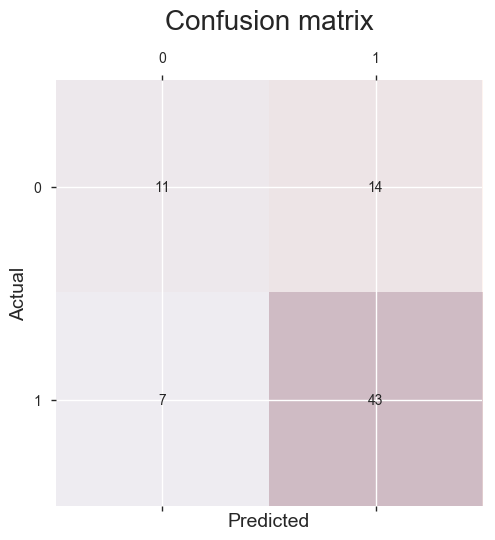

In [267]:
# XGBoost Confusion Matrix
y_true = y_test
y_pred = xgb_predictions
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap = plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x = j, y = i, s = conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

<module 'matplotlib.pyplot' from '/Users/yuce/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

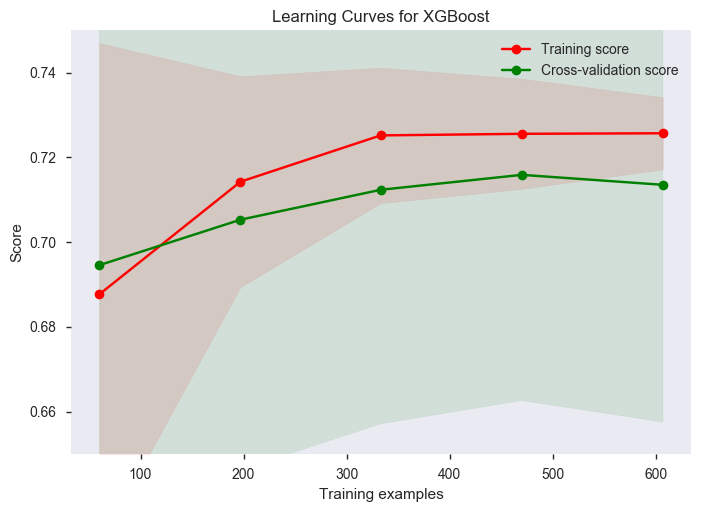

In [268]:
# XGBoost Learning Curve

title = "Learning Curves for XGBoost"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=0)

estimator = XGBClassifier(objective="binary:logistic",
                            learning_rate=0.01,
                            n_estimators=100,
                            max_depth=2,
                            subsample=0.1,
                            random_state=123)

plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.65, 0.75), cv=cv, n_jobs=4)
      

## Logistic Regression

In [269]:
# Grid Search for Logistic

param_grid = {'C': np.power(10.0, np.arange(-10, 10))}
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)

GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

best_model = clf.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 10.0


In [270]:
logistic = LogisticRegression(penalty = 'l2', 
                              C = 10)

pip_baseline = make_pipeline(RobustScaler(), logistic)
scores = cross_val_score(pip_baseline,
                         X_train, y_train,
                         scoring = "roc_auc", cv = 5)

logistic.fit(X_train,y_train)

logistic_predictions = logistic.predict(X_test)
logistic_prob = logistic.predict_proba(X_test)

scores_log = cross_val_score(logistic,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)


print("\n========================================================")
print(" Results from Logistic Regression " )
print("========================================================")  
print("\n")
print(f"Logistic Regression model's average AUC: {scores_log.mean():.3f}")
print("\n")
print(classification_report(y_test, logistic_predictions))
print("\n========================================================")
print("\n")
print(f"Logistic Regression's Accuracy Score is: {accuracy_score(y_true, y_pred)}")
print(f"Logistic Regression's Precision Score is {precision_score(y_true, y_pred, average='weighted')}")
print("\n")




 Results from Logistic Regression 


Logistic Regression model's average AUC: 0.733


              precision    recall  f1-score   support

         0.0       0.75      0.48      0.59        25
         1.0       0.78      0.92      0.84        50

   micro avg       0.77      0.77      0.77        75
   macro avg       0.76      0.70      0.71        75
weighted avg       0.77      0.77      0.76        75




Logistic Regression's Accuracy Score is: 0.72
Logistic Regression's Precision Score is 0.7066276803118908




<Figure size 1600x800 with 0 Axes>

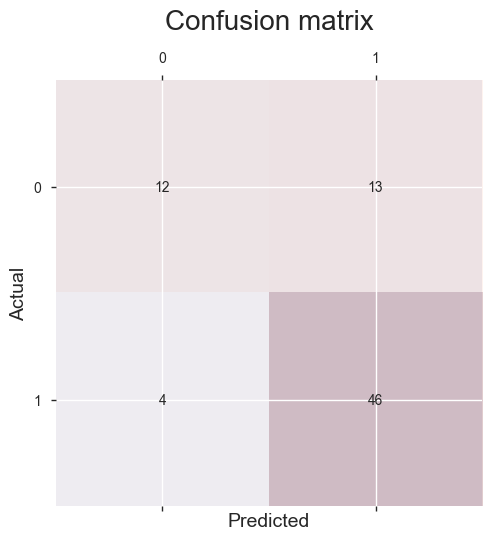

In [271]:
# Logistic Reg. Confusion Matrix
y_true = y_test
y_pred = logistic_predictions
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap = plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x = j, y = i, s = conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

<module 'matplotlib.pyplot' from '/Users/yuce/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

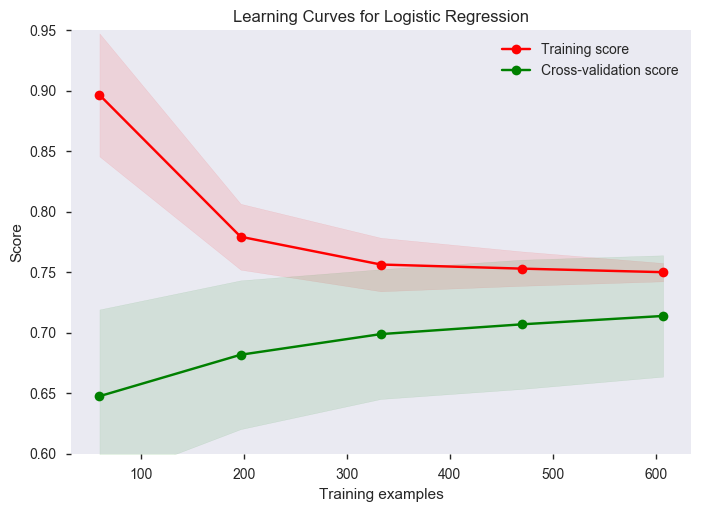

In [272]:
# Logistic Reg. Learning Curve

title = "Learning Curves for Logistic Regression"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=0)

estimator = LogisticRegression(penalty = 'l2', C = 1, 
                                           class_weight={1:4, 0:6})

plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.6, 0.95), cv=cv, n_jobs=4)


### Stacking

In [273]:
from vecstack import StackingTransformer


In [274]:
estimators = [("brf", BalancedRandomForestClassifier(n_estimators = 50, 
                                                     random_state=123,
                                                     n_jobs = -1, 
                                                     max_depth = 2)),
              ("xgb", XGBClassifier(objective="binary:logistic",
                    learning_rate=0.1,
                    n_estimators=200,
                    max_depth=2,
                    subsample=0.7,
                    random_state=123,
                    colsample_bytree = 0.7,
                    gamma = 0.1,
                    min_child_weight = 6,
                    reg_alpha = 0.01)),
              ("logit", LogisticRegression(penalty = 'l2', 
                                           C = 1, 
                                           class_weight={1:4, 0:6}))   
]


In [275]:
stack = StackingTransformer(estimators, regression = False, verbose = 2)

In [276]:
stack = stack.fit(X_train, y_train)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [3]

estimator  0: [brf: BalancedRandomForestClassifier]
    fold  0:  [0.63905325]
    fold  1:  [0.65680473]
    fold  2:  [0.66272189]
    fold  3:  [0.63690476]
    ----
    MEAN:     [0.64887116] + [0.01111722]

estimator  1: [xgb: XGBClassifier]
    fold  0:  [0.69822485]
    fold  1:  [0.73372781]
    fold  2:  [0.73372781]
    fold  3:  [0.75000000]
    ----
    MEAN:     [0.72892012] + [0.01892610]

estimator  2: [logit: LogisticRegression]
    fold  0:  [0.72189349]
    fold  1:  [0.72781065]
    fold  2:  [0.71597633]
    fold  3:  [0.70238095]
    ----
    MEAN:     [0.71701536] + [0.00942841]



In [277]:
S_train = stack.transform(X_train)
S_test = stack.transform(X_test)

Train set was detected.
Transforming...

estimator  0: [brf: BalancedRandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [xgb: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  2: [logit: LogisticRegression]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

Transforming...

estimator  0: [brf: BalancedRandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [xgb: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  2: [logit: LogisticRegression]
    model


 Results from Stacked Model


Stacked Model's average AUC: 0.755


              precision    recall  f1-score   support

         0.0       0.56      0.36      0.44        25
         1.0       0.73      0.86      0.79        50

   micro avg       0.69      0.69      0.69        75
   macro avg       0.65      0.61      0.61        75
weighted avg       0.67      0.69      0.67        75




Stacked Model's Accuracy Score is: 0.6933333333333334
Stacked Model's Precision Score is 0.6733757062146892




<module 'matplotlib.pyplot' from '/Users/yuce/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<Figure size 1600x800 with 0 Axes>

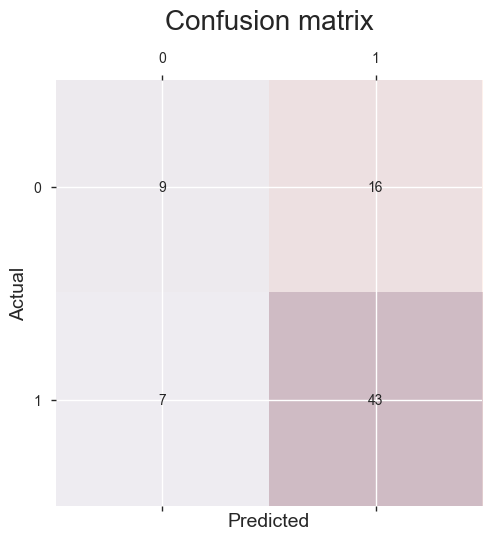

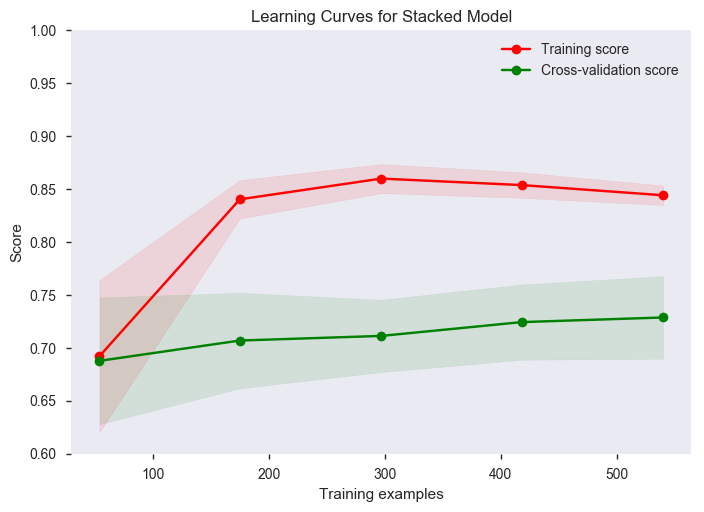

In [278]:
model = XGBClassifier(objective="binary:logistic",
                    learning_rate=0.1,
                    n_estimators=200,
                    max_depth=2,
                    subsample=0.7,
                    random_state=123,
                    colsample_bytree = 0.7,
                    gamma = 0.1,
                    min_child_weight = 6,
                    reg_alpha = 0.01)

pip_baseline = make_pipeline(RobustScaler(), model)
scores_stk = cross_val_score(pip_baseline,
                         X_train, y_train,
                         scoring = "roc_auc", cv = 4)

model = model.fit(S_train, y_train)

y_pred = model.predict(S_test)

print("\n========================================================")
print(" Results from Stacked Model" )
print("========================================================")
print("\n")
print(f"Stacked Model's average AUC: {scores_stk.mean():.3f}")
print("\n")
print(classification_report(y_test, y_pred))
print("\n========================================================")
print("\n")
print(f"Stacked Model's Accuracy Score is: {accuracy_score(y_true, y_pred)}")
print(f"Stacked Model's Precision Score is {precision_score(y_true, y_pred, average='weighted')}")
print("\n")

# Confusion Matrix
y_true = y_test
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap = plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x = j, y = i, s = conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

title = "Learning Curves for Stacked Model"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = model

plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.6, 1), cv=cv, n_jobs=4)
      

### SUMMARY

In [279]:
print(f"Balanced RF's average AUC: {scores.mean():.3f}")
print(f"XGB's average AUC: {scores_xgb.mean():.3f}")
print(f"Logistic Regression's average AUC: {scores_log.mean():.3f}")
print(f"Stacked Model's average AUC: {scores_stk.mean():.3f}")

Balanced RF's average AUC: 0.737
XGB's average AUC: 0.750
Logistic Regression's average AUC: 0.733
Stacked Model's average AUC: 0.755


# Testing the Classifier

In [226]:
# df_merged.to_csv("test_file.csv")

In [227]:
# test_df = pd.read_csv("test_file.csv")
# test2_df = pd.read_csv("test_file2.csv")

In [228]:
# # Simple tester function

# def cust_class(x):
#     if x == 1:
#         print("Loan application has been APPROVED.")
#     else:
#         print("Loan application has been REJECTED.")

#### Test 1

In [229]:
# cust_class(logistic.predict(test_df))

#### Test 2

In [230]:
# cust_class(logistic.predict(test2_df))

### Some Test Results

In [ ]:

'''

AUC SCORES

Baseline model's average AUC: 0.508
Random Forest's average AUC: 0.766
XGB's average AUC: 0.759
Logistic Regression model's average AUC: 0.736

With stability feature
Baseline model's average AUC: 0.501
Random Forest's average AUC: 0.758
XGB's average AUC: 0.745
Logistic Regression model's average AUC: 0.728

Without stability feature & adjusted features
Baseline model's average AUC: 0.474
Random Forest's average AUC: 0.763
XGB's average AUC: 0.745
Logistic Regression model's average AUC: 0.733


ACCURACY & PRECISION SCORES

80/20 split, class_weights:4/6
Random Forest's Accuracy Score is: 0.5533333333333333
Random Forest's Precision Score is 0.6904055838521034

XGBoost's Accuracy Score is: 0.5066666666666667
XGBoost's Precision Score is 0.6745751633986928

Logistic Regression's Accuracy Score is: 0.7
Logistic Regression's Precision Score is 0.6794612794612794

85/15 split, class_weights:4/6
Random Forest's Accuracy Score is: 0.4690265486725664
Random Forest's Precision Score is 0.739835385853085

XGBoost's Accuracy Score is: 0.5398230088495575
XGBoost's Precision Score is 0.7150710646285868

Logistic Regression's Accuracy Score is: 0.7256637168141593
Logistic Regression's Precision Score is 0.7102767540668058

90/10 split, class_weights:4/6
Random Forest's Accuracy Score is: 0.5733333333333334
Random Forest's Precision Score is 0.706959706959707

XGBoost's Accuracy Score is: 0.5466666666666666
XGBoost's Precision Score is 0.69281045751634

Logistic Regression's Accuracy Score is: 0.7066666666666667
Logistic Regression's Precision Score is 0.6929824561403509


'''